In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from sklearn.utils.extmath import cartesian
from geopy.distance import geodesic
import torch

In [2]:
# start_month: 1-12
def download_data(start_year, start_month=1, path = 'Data'):
  start_month = start_month - 1

  months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
  start_year = 2017 if start_year < 2017 else start_year # limiting to 2017 because they had different data structures before that
  end_year = 2023
  end_month = 3
  data_frames = []

  for i in range(12 * (end_year - start_year) + end_month - start_month):
    month = months[(i + start_month) % 12]
    year = int(start_year + (i + start_month) / 12)
    
    #Use below for google colab
    '''
    !echo http://s3.amazonaws.com/tripdata/$year$month-citibike-tripdata.csv.zip
    !wget -q http://s3.amazonaws.com/tripdata/$year$month-citibike-tripdata.csv.zip
    !unzip -o $year$month-citibike-tripdata.csv.zip
    # for some reason these downloads fail, we can upload the data manually
    if not (year == 2022 and month == "06") and not (year == 2022 and month == "07"):
      data_frames.append(pd.read_csv("{}{}-citibike-tripdata.csv".format(year, month)))
    '''
    #Use below for not google colab (must download and extract csv files into folder specified by path parameter)
    data_frames.append(pd.read_csv(path + "\{}{}-citibike-tripdata.csv".format(year, month)))
  
  final_df = pd.concat(data_frames, axis=0, ignore_index=True)
  data_frames = []
  final_df.dropna(inplace=True) # drop NaN
  final_df = final_df.sort_values(by="started_at") # sort by start time

  return final_df

df = download_data(2023, 3)
df.head() # we will split train/test data later

c:\Users\mehul\Anaconda3\envs\GNN_Research\lib\site-packages\ipykernel_launcher.py:34: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
704451,ECE8DD5F42A4DC7B,classic_bike,2023-03-01 00:00:03,2023-03-01 00:05:14,Hanson Pl & Ashland Pl,4395.07,Carroll St & 6 Ave,4019.06,40.685010,-73.977699,40.674089,-73.978728,member
1696235,C36627A7EF6F32DB,electric_bike,2023-03-01 00:00:18,2023-03-01 00:33:16,LaGuardia Pl & W 3 St,5721.14,LaGuardia Pl & W 3 St,5721.14,40.729170,-73.998102,40.729170,-73.998102,member
1430211,837ECA56CB7EC87B,classic_bike,2023-03-01 00:00:22,2023-03-01 00:05:15,E 20 St & FDR Dr,5886.13,University Pl & E 14 St,5905.14,40.733272,-73.975632,40.734814,-73.992085,member
1021853,EDCE1C1D0408C24E,classic_bike,2023-03-01 00:00:28,2023-03-01 00:15:16,W 47 St & 10 Ave,6824.07,Sullivan St & Washington Sq,5721.01,40.762726,-73.993001,40.730477,-73.999061,member
2141632,7DB86DAEE8F1C40B,classic_bike,2023-03-01 00:00:29,2023-03-01 00:05:54,1 Ave & E 110 St,7522.02,Central Park North & Adam Clayton Powell Blvd,7617.07,40.792351,-73.938264,40.799484,-73.955613,member


In [3]:

#This code does not take into account if there are some end stations that are not in start stations
# Reassign the station id to a standard #
locations = df['start_station_id'].unique()
new_ids = list(range(len(df['start_station_id'].unique())))
mapping = dict(zip(locations, new_ids))

df['start_station_id'] = df['start_station_id'].map(mapping)
df['end_station_id'] = df['end_station_id'].map(mapping)

'''
#Reassigns station id to a standard #, taking to account if there are some end stations not in start stations and vice verso
all_location_ids = np.concatenate((data['start_station_id'].values, data['end_station_id']), axis=0).astype(str)
all_location_ids = np.unique(all_location_ids)
new_ids = list(range(len(all_location_ids)))
mapping = dict(zip(all_location_ids, new_ids))

data['start_station_id'] = data['start_station_id'].astype(str).map(mapping)
data['end_station_id'] = data['end_station_id'].astype(str).map(mapping)
'''

"\n#Reassigns station id to a standard #, taking to account if there are some end stations not in start stations and vice verso\nall_location_ids = np.concatenate((data['start_station_id'].values, data['end_station_id']), axis=0).astype(str)\nall_location_ids = np.unique(all_location_ids)\nnew_ids = list(range(len(all_location_ids)))\nmapping = dict(zip(all_location_ids, new_ids))\n\ndata['start_station_id'] = data['start_station_id'].astype(str).map(mapping)\ndata['end_station_id'] = data['end_station_id'].astype(str).map(mapping)\n"

In [4]:
df = df.dropna()

In [5]:
# convert strings into date objects
df["started_at"] = pd.to_datetime(df["started_at"], format="%Y-%m-%d %H:%M:%S")
df["ended_at"] = pd.to_datetime(df["ended_at"], format="%Y-%m-%d %H:%M:%S")

# calculate strip duration in seconds
df['trip_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds()

df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
1430211,837ECA56CB7EC87B,classic_bike,2023-03-01 00:00:22,2023-03-01 00:05:15,E 20 St & FDR Dr,2,University Pl & E 14 St,87.0,40.733272,-73.975632,40.734814,-73.992085,member,293.0
1067453,608DA83170DF68BB,classic_bike,2023-03-01 00:00:31,2023-03-01 00:21:21,E 33 St & 1 Ave,5,South St & Whitehall St,701.0,40.743553,-73.975172,40.701221,-74.012342,member,1250.0
495152,E288F7A86C3EEE2E,classic_bike,2023-03-01 00:01:02,2023-03-01 00:07:13,Kenmare St & Elizabeth St,15,Pike St & E Broadway,139.0,40.720691,-73.994833,40.714067,-73.992939,member,371.0
807832,1E7B0092BF86C8E9,classic_bike,2023-03-01 00:01:27,2023-03-01 00:04:15,Pacific St & Troy Ave,16,Bergen St & Kingston Ave,1015.0,40.676860,-73.936070,40.675600,-73.941500,member,168.0
1393964,C10170585EFC4497,classic_bike,2023-03-01 00:01:29,2023-03-01 00:48:54,W 20 St & 5 Ave,7,Broadway & W 48 St,343.0,40.739730,-73.991040,40.760177,-73.984868,casual,2845.0


In [6]:
outgoing_trips = df.groupby("start_station_id").count()
incoming_trips = df.groupby("end_station_id").count()

In [7]:
import numpy as np
# Find out how many outgoing bikers we have
outgoing_trips = df.groupby("start_station_id").count()
incoming_trips = df.groupby("end_station_id").count()

# Match the list sizes
actual_incoming_trips = []
for idx in outgoing_trips.index:
  if idx not in incoming_trips.index:
    actual_incoming_trips.append(0)
  else:
    actual_incoming_trips.append(incoming_trips.loc[[idx]]['ride_id'].values[0])

actual_incoming_trips = np.asarray(actual_incoming_trips)
incoming_trips = actual_incoming_trips
outgoing_trips = outgoing_trips['ride_id'].values

# Normalize features between 0 and 1
outgoing_trips = (outgoing_trips - np.min(outgoing_trips)) / (np.max(outgoing_trips) - np.min(outgoing_trips))
incoming_trips = (incoming_trips - np.min(incoming_trips)) / (np.max(incoming_trips) - np.min(incoming_trips))

node_features = np.stack([outgoing_trips, incoming_trips]).transpose()
print("Full shape: ", node_features.shape)
node_features[0:5]

Full shape:  (1808, 2)


array([[0.18424705, 0.        ],
       [0.23108952, 0.        ],
       [0.35877863, 0.        ],
       [0.32061069, 0.        ],
       [0.07078418, 0.        ]])

In [8]:
from pandas._libs.tslibs.offsets import YearOffset
start_date = df.iloc[0]['started_at']
end_date = df.iloc[-1]['started_at']
interval = timedelta(hours=3)


labels = []

#stop = start_date + timedelta(hours=24)
#while start_date <= stop:
while start_date <= end_date:
    
    current_snapshot = df[((start_date + interval) >= df["ended_at"]) & (start_date <= df["ended_at"])]
    
    # Compute average duration of trips along the same edge
    current_snapshot = current_snapshot.groupby(["start_station_id", "end_station_id"]).mean().reset_index()
    
    # Labels as the number of outgoing trips from each station within this hour
    start_stations = np.zeros_like(df["start_station_id"].unique())

    y = current_snapshot.groupby("start_station_id").count()['start_lat'].values
    y_index = np.unique(current_snapshot[["start_station_id"]].values.transpose())

    
    start_stations[y_index] = y
    labels.append(start_stations)

    start_date += interval


In [9]:
outgoing = np.array(labels)

In [10]:
from typing import Tuple
import math
#need to create features np array and targets np array
#using sliding window
#parameters time_steps_in and time_steps_out
#should use 24 hours for proof of concept
def sliding_window(data: np.array, timestep_in: int, timestep_out: int, overlap = True) -> Tuple[np.array, np.array]:
    print(data.dtype)
    if(overlap):
        n = len(data)
        if(timestep_in + timestep_out > len(data)):
            print("Timestep sizes (" + str(timestep_in) + ", " + str(timestep_out) + ") are too large for data length: " + str(n))
        else:
            x = torch.from_numpy(np.array([data[i: i + timestep_in] for i in range(n - timestep_in - timestep_out + 1)], dtype = int)).type(torch.FloatTensor)
            x = x[:, :, None]
            y = torch.from_numpy(np.array([data[i: i + timestep_out] for i in range(timestep_in, n - timestep_out + 1)], dtype = int)).type(torch.FloatTensor)
            y = y[:, :, None]
            return(x, y)
    else:
        n = len(data)
        if(timestep_in + timestep_out > len(data)):
            print("Timestep sizes (" + str(timestep_in) + ", " + str(timestep_out) + ") are too large for data length: " + str(n))
        else:
            total = np.array([data[i: i + timestep_in + timestep_out] for i in range(0, n - timestep_in + 1, timestep_out + timestep_in)])
            x = torch.from_numpy(np.array([arr[0:timestep_in] for arr in total], dtype = int)).type(torch.FloatTensor)
            x = x[:, :, None]
            y = torch.from_numpy(np.array([arr[timestep_in:] for arr in total], dtype = int)).type(torch.FloatTensor)
            y = y[:, :, None]
            return(x, y)

x, y = sliding_window(np.arange(24), 4, 2, False)
print(len(x) == len(y))
#for i in range(len(x)):
    #print(str(x[i]) + "  :      " + str(y[i]))

int32
True


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

biggest_sensor = np.argmax(np.sum(outgoing, axis=1))
np.shape(labels)[0]
train_labels = np.array(labels)[0:int(np.shape(labels)[0] * 0.7), biggest_sensor]
test_labels = np.array(labels)[int(np.shape(labels)[0] * 0.7):, biggest_sensor]

#used https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/ to help with syntax & implementation in this cell
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
X_train, y_train = sliding_window(train_labels, 12, 12, True)
X_test, y_test = sliding_window(test_labels, 12, 12, True)
model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
dataset = data.TensorDataset(X_train, y_train)
loader = data.DataLoader(dataset, shuffle=True, batch_size=8)
train_losses = []
test_losses = []

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    #if epoch % 100 != 0:
    #    continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        train_losses.append(loss_fn(y_pred, y_train).item())
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        test_losses.append(loss_fn(y_pred, y_test).item())
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

int64
int64
Epoch 0: train RMSE 2.6992, test RMSE 2.1027
0
Epoch 1: train RMSE 2.2373, test RMSE 1.8382
1
Epoch 2: train RMSE 2.1834, test RMSE 1.8947
2
Epoch 3: train RMSE 2.1433, test RMSE 1.8290
3
Epoch 4: train RMSE 2.0990, test RMSE 1.8449
4
Epoch 5: train RMSE 2.0324, test RMSE 1.8206
5
Epoch 6: train RMSE 1.9426, test RMSE 1.7954
6
Epoch 7: train RMSE 1.8885, test RMSE 1.8404
7
Epoch 8: train RMSE 1.8557, test RMSE 1.8212
8
Epoch 9: train RMSE 1.8344, test RMSE 1.8224
9
Epoch 10: train RMSE 1.8183, test RMSE 1.7826
10
Epoch 11: train RMSE 1.8021, test RMSE 1.8196
11
Epoch 12: train RMSE 1.7922, test RMSE 1.8481
12
Epoch 13: train RMSE 1.7795, test RMSE 1.8364
13
Epoch 14: train RMSE 1.7692, test RMSE 1.8254
14
Epoch 15: train RMSE 1.7595, test RMSE 1.7981
15
Epoch 16: train RMSE 1.7504, test RMSE 1.8186
16
Epoch 17: train RMSE 1.7425, test RMSE 1.8090
17
Epoch 18: train RMSE 1.7364, test RMSE 1.8060
18
Epoch 19: train RMSE 1.7293, test RMSE 1.8118
19
Epoch 20: train RMSE 1.7242,

In [19]:
loss_tuples = list(zip(training_mses, testing_mses))
loss_df = pd.DataFrame(loss_tuples, columns=["Training MSE", "Testing MSE"])
loss_df.to_csv("Data/lstm.csv")

In [32]:
y_test = torch.squeeze(y_test)
y_pred = torch.squeeze(y_pred)

In [45]:
predictions = [pred.detach().numpy()[0] for pred in y_pred]
actual = [t.detach().numpy()[0] for t in y_test]

<AxesSubplot:>

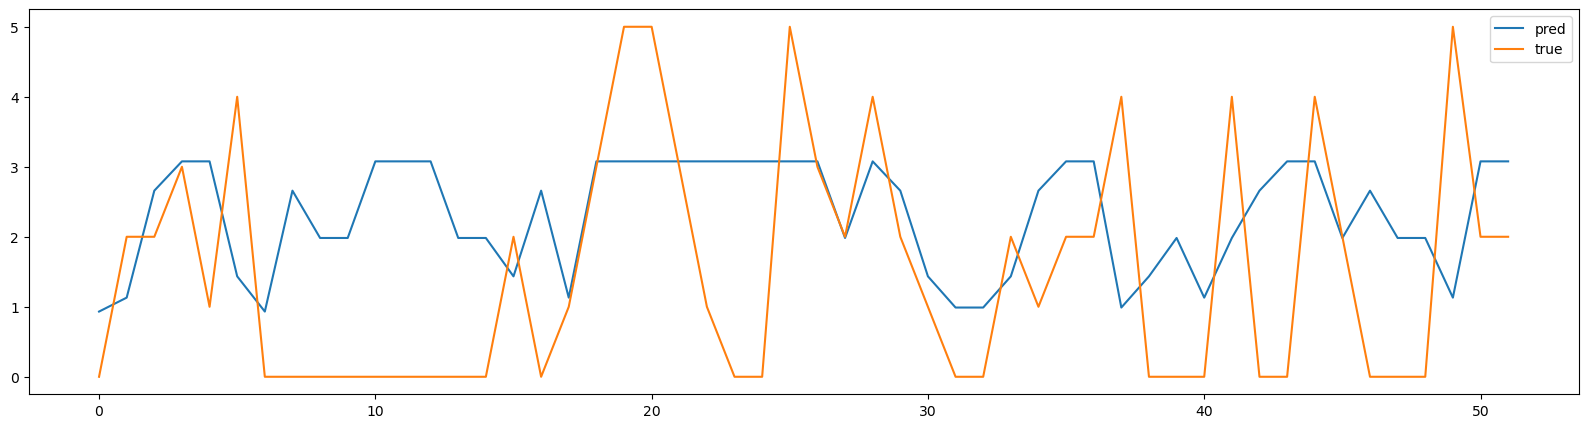

In [49]:
import seaborn as sns
plt.figure(figsize=(20,5))
sns.lineplot(data=predictions, label="pred")
sns.lineplot(data=actual, label="true")